## Generative Classifier Implementation

In this question, you are asked to train two generative classifiers (Naive Bayes and k-NN) from scratch to dealing with a classification task. The heart failure prediction dataset contains 11 common features (e.g., age, sex, and several medical predictor variables) from 918 patient examples that can be used to predict whether the patient has heart disease (1) or not (0).

Dataset


1. Age: age of the patient [years]
2. Sex: sex of the patient [M: Male, F: Female]
3. ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4. RestingBP: resting blood pressure [mm Hg]
5. Cholesterol: serum cholesterol [mm/dl]
6. FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
7. RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
8. MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
9. ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
10. Oldpeak: oldpeak = ST [Numeric value measured in depression]
11. ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
12. HeartDisease: output class [1: heart disease, 0: Normal]


##### Tasks:
1. Split the 918 instances into training and test sets (8:2) for Naive Bayes classifier. This is because the features have already been manually selected and no further tuning is necessary. While for the k-NN classifier, you need to split the instances into training, validation, and test sets as (6:2:2). The validation set is used to fine-tune the hyper-parameter k. (10 points)
2. Train your Naive Bayes and k-NN Classifiers on the training set. (60 points)
3. After training, test your classifier on the test set, report the confusion matrices and accuracy, precision, recall, and F1-score, these metrics are calculated from confusion matrix. (30 points)

##### Guidelines (for k-NN only):
1. Use Euclidean distance (L2) to compute distances between instances. As the attributes in Heart Disease dataset are either categorical or continuous. In the case of mix of these two, the categorical variables may be mapped to numerical values (through one-hot encoding) before applying the k-NN algorithm.
2. Each continuous feature should be normalized separately from all other features. Specifically, for both training and testing instances, each feature should be transformed using function F (X) = (X ‚àímean)/std, using the mean and std of the values of that feature on the training data.

### Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,classification_report

import warnings
warnings.filterwarnings('ignore')

### Loading the Datafile and doing basic EDA

In [2]:
dataFrame = pd.read_csv("heart.csv")
dataFrame

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
0     40   M           ATA        140          289          0     Normal   
1     49   F           NAP        160          180          0     Normal   
2     37   M           ATA        130          283          0         ST   
3     48   F           ASY        138          214          0     Normal   
4     54   M           NAP        150          195          0     Normal   
..   ...  ..           ...        ...          ...        ...        ...   
913   45   M            TA        110          264          0     Normal   
914   68   M           ASY        144          193          1     Normal   
915   57   M           ASY        130          131          0     Normal   
916   57   F           ATA        130          236          0        LVH   
917   38   M           NAP        138          175          0     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0      172              N      0.0       Up             0  
1      156              N      1.0     Flat             1  
2       98              N      0.0       Up             0  
3      108              Y      1.5     Flat             1  
4      122              N      0.0       Up             0  
..     ...            ...      ...      ...           ...  
913    132              N      1.2     Flat             1  
914    141              N      3.4     Flat             1  
915    115              Y      1.2     Flat             1  
916    174              N      0.0     Flat             1  
917    173              N      0.0       Up             0  

[918 rows x 12 columns]

<AxesSubplot:>

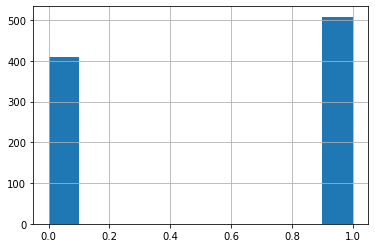

In [3]:
#checking how the target variable is distributed
dataFrame["HeartDisease"].hist()

In [4]:
dataFrame["HeartDisease"].value_counts()

1    508
0    410
Name: HeartDisease, dtype: int64

In [5]:
# we have 918 rows 
# 11 Attributes (6 Numeric and 5 Categorical), and target column (HeartDisease)

dataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


##### There is a bit imbalance in the dataset as there are more data with class 1 [people with heart disease] than class 0 [people with no heart disease] 

In [6]:
#separating the continuous and categorical columns

df_continuous = dataFrame[['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']]
df_categorical = dataFrame[['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope']]

<AxesSubplot:>

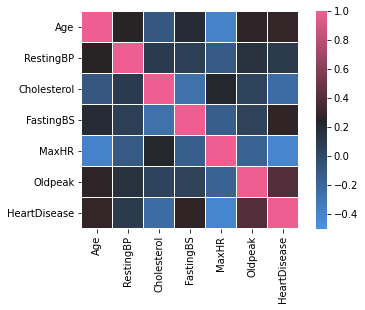

In [7]:
#corr = df.corr(method = "pearson")
corr = df_continuous.corr(method = "pearson")
cmap = sns.diverging_palette(250,354,80,60, center = 'dark', as_cmap = True)
sns.heatmap(corr, vmax = 1, vmin = -0.5, cmap = cmap, square = True, linewidth = 0.2)

##### the features are independent of each other as there is no strong positive correlation which is perfect for Naive Bayes

In [8]:
dataFrame.isnull().sum()   #No null values present

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

### One Hot Encoding

In [9]:
dummie_sex = pd.get_dummies(dataFrame.Sex)
dummie_EA = pd.get_dummies(dataFrame.ExerciseAngina)
dummie_CP = pd.get_dummies(dataFrame.ChestPainType)
dummie_RECG = pd.get_dummies(dataFrame.RestingECG)
dummie_STS = pd.get_dummies(dataFrame.ST_Slope)

In [10]:
#Merging dummy variables
merged_dataFrame = pd.concat([dataFrame,dummie_sex,dummie_EA,dummie_CP,dummie_RECG,dummie_STS],axis=1)
pd.set_option('display.max_columns', None)
merged_dataFrame.head()

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  F  M  N  Y  ASY  ATA  NAP  \
0              N      0.0       Up             0  0  1  1  0    0    1    0   
1              N      1.0     Flat             1  1  0  1  0    0    0    1   
2              N      0.0       Up             0  0  1  1  0    0    1    0   
3              Y      1.5     Flat             1  1  0  0  1    1    0    0   
4              N      0.0       Up             0  0  1  1  0    0    0    1   

   TA  LVH  Normal  ST  Down  Flat  Up  
0   0    0       1   0     0     0   1  
1   0    0       1   0     0     1   0  
2   0    0       0   1     0     0   1  
3   0    0       1   0     0     1   0  
4   0    0       1   0     0     0   1

In [11]:
#dropping the categorical columns
final_dataFrame = merged_dataFrame.drop(['Sex','ExerciseAngina','ChestPainType','RestingECG','ST_Slope'], axis=1)
pd.set_option('display.max_columns', None)
final_dataFrame.head()

Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  HeartDisease  F  M  \
0   40        140          289          0    172      0.0             0  0  1   
1   49        160          180          0    156      1.0             1  1  0   
2   37        130          283          0     98      0.0             0  0  1   
3   48        138          214          0    108      1.5             1  1  0   
4   54        150          195          0    122      0.0             0  0  1   

   N  Y  ASY  ATA  NAP  TA  LVH  Normal  ST  Down  Flat  Up  
0  1  0    0    1    0   0    0       1   0     0     0   1  
1  1  0    0    0    1   0    0       1   0     0     1   0  
2  1  0    0    1    0   0    0       0   1     0     0   1  
3  0  1    1    0    0   0    0       1   0     0     1   0  
4  1  0    0    0    1   0    0       1   0     0     0   1

In [12]:
final_dataFrame.describe()

Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  918.000000  918.000000   918.000000  918.000000  918.000000   
mean    53.510893  132.396514   198.799564    0.233115  136.809368   
std      9.432617   18.514154   109.384145    0.423046   25.460334   
min     28.000000    0.000000     0.000000    0.000000   60.000000   
25%     47.000000  120.000000   173.250000    0.000000  120.000000   
50%     54.000000  130.000000   223.000000    0.000000  138.000000   
75%     60.000000  140.000000   267.000000    0.000000  156.000000   
max     77.000000  200.000000   603.000000    1.000000  202.000000   

          Oldpeak  HeartDisease           F           M           N  \
count  918.000000    918.000000  918.000000  918.000000  918.000000   
mean     0.887364      0.553377    0.210240    0.789760    0.595861   
std      1.066570      0.497414    0.407701    0.407701    0.490992   
min     -2.600000      0.000000    0.000000    0.000000    0.000000   
25%      0.000000      0.000000    0.000000    1.000000    0.000000   
50%      0.600000      1.000000    0.000000    1.000000    1.000000   
75%      1.500000      1.000000    0.000000    1.000000    1.000000   
max      6.200000      1.000000    1.000000    1.000000    1.000000   

                Y         ASY         ATA         NAP          TA         LVH  \
count  918.000000  918.000000  918.000000  918.000000  918.000000  918.000000   
mean     0.404139    0.540305    0.188453    0.221133    0.050109    0.204793   
std      0.490992    0.498645    0.391287    0.415236    0.218289    0.403770   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    1.000000    0.000000    0.000000    0.000000    0.000000   
75%      1.000000    1.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

           Normal          ST        Down        Flat          Up  
count  918.000000  918.000000  918.000000  918.000000  918.000000  
mean     0.601307    0.193900    0.068627    0.501089    0.430283  
std      0.489896    0.395567    0.252957    0.500271    0.495386  
min      0.000000    0.000000    0.000000    0.000000    0.000000  
25%      0.000000    0.000000    0.000000    0.000000    0.000000  
50%      1.000000    0.000000    0.000000    1.000000    0.000000  
75%      1.000000    0.000000    0.000000    1.000000    1.000000  
max      1.000000    1.000000    1.000000    1.000000    1.000000

## 1. Naive Bayes Classification 

In [13]:
#copy the final dataframe to a new one for Naive Bayes Classification

df_nb = final_dataFrame.copy()

In [14]:
df_nb.shape

(918, 21)

In [15]:
df_nb.head()

Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  HeartDisease  F  M  \
0   40        140          289          0    172      0.0             0  0  1   
1   49        160          180          0    156      1.0             1  1  0   
2   37        130          283          0     98      0.0             0  0  1   
3   48        138          214          0    108      1.5             1  1  0   
4   54        150          195          0    122      0.0             0  0  1   

   N  Y  ASY  ATA  NAP  TA  LVH  Normal  ST  Down  Flat  Up  
0  1  0    0    1    0   0    0       1   0     0     0   1  
1  1  0    0    0    1   0    0       1   0     0     1   0  
2  1  0    0    1    0   0    0       0   1     0     0   1  
3  0  1    1    0    0   0    0       1   0     0     1   0  
4  1  0    0    0    1   0    0       1   0     0     0   1

### Gaussian Naive Bayes
Gaussian Naive Bayes is useful when working with continuous values which probabilities can be modeled using a Gaussian distribution:

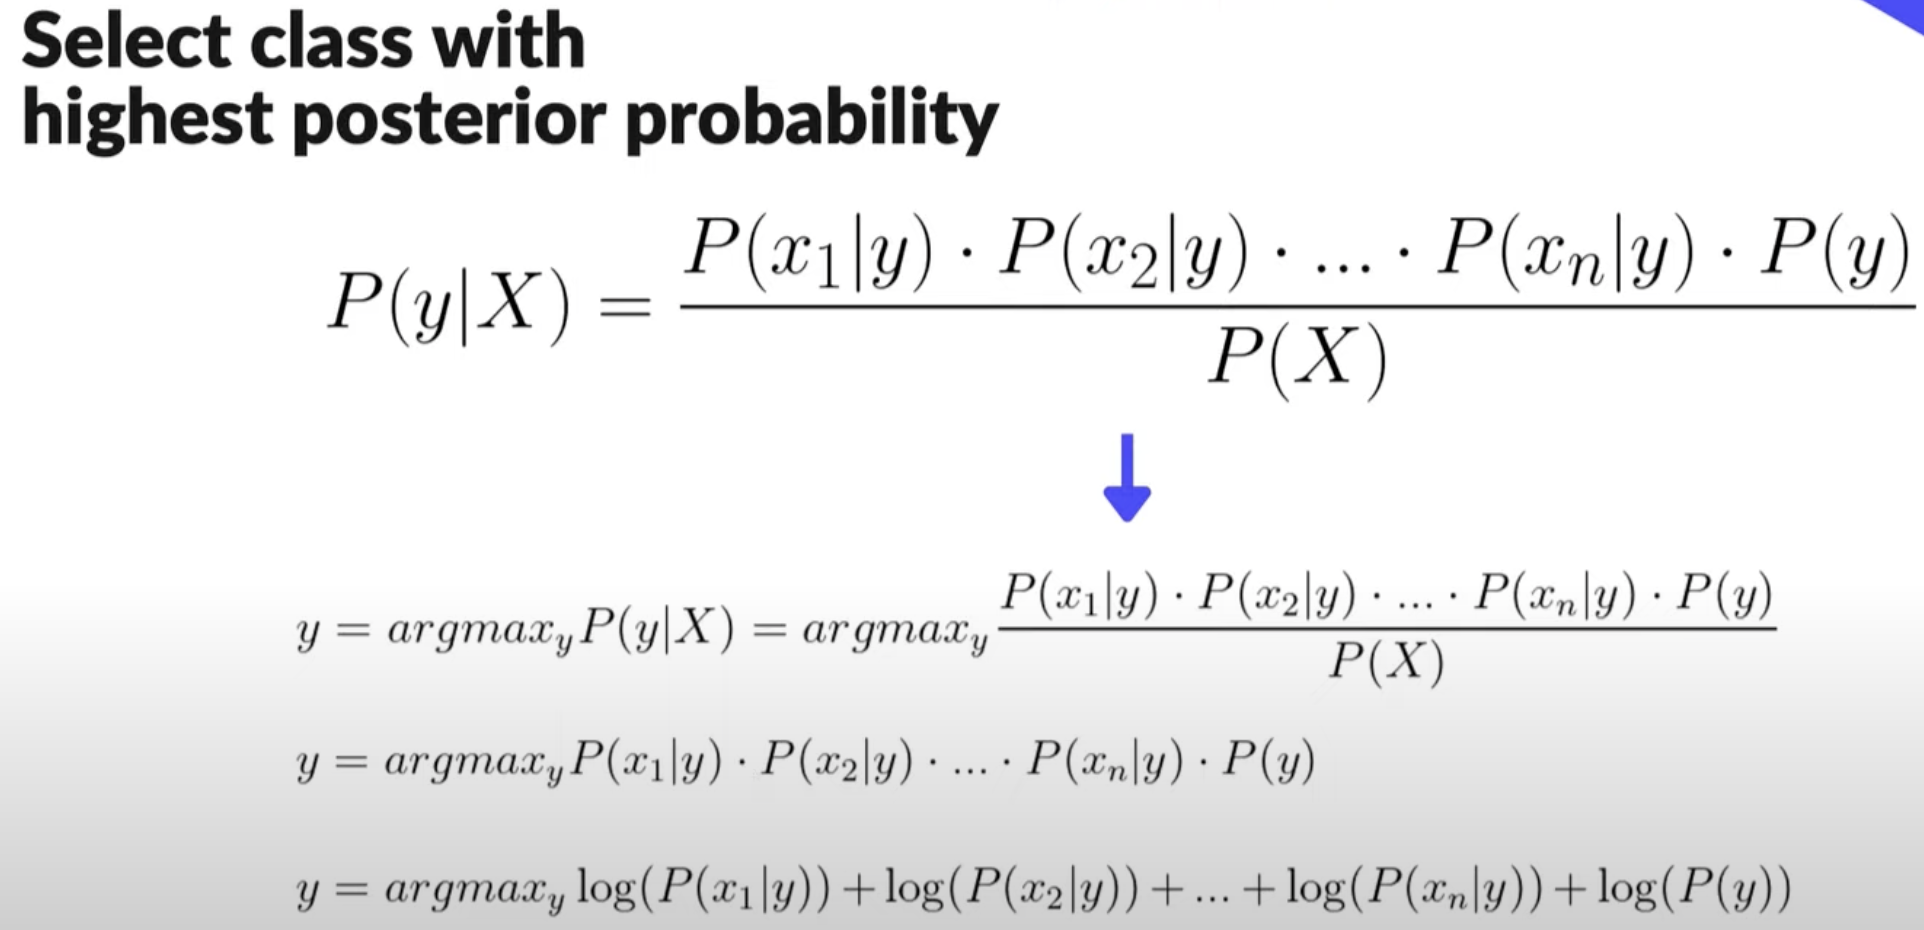

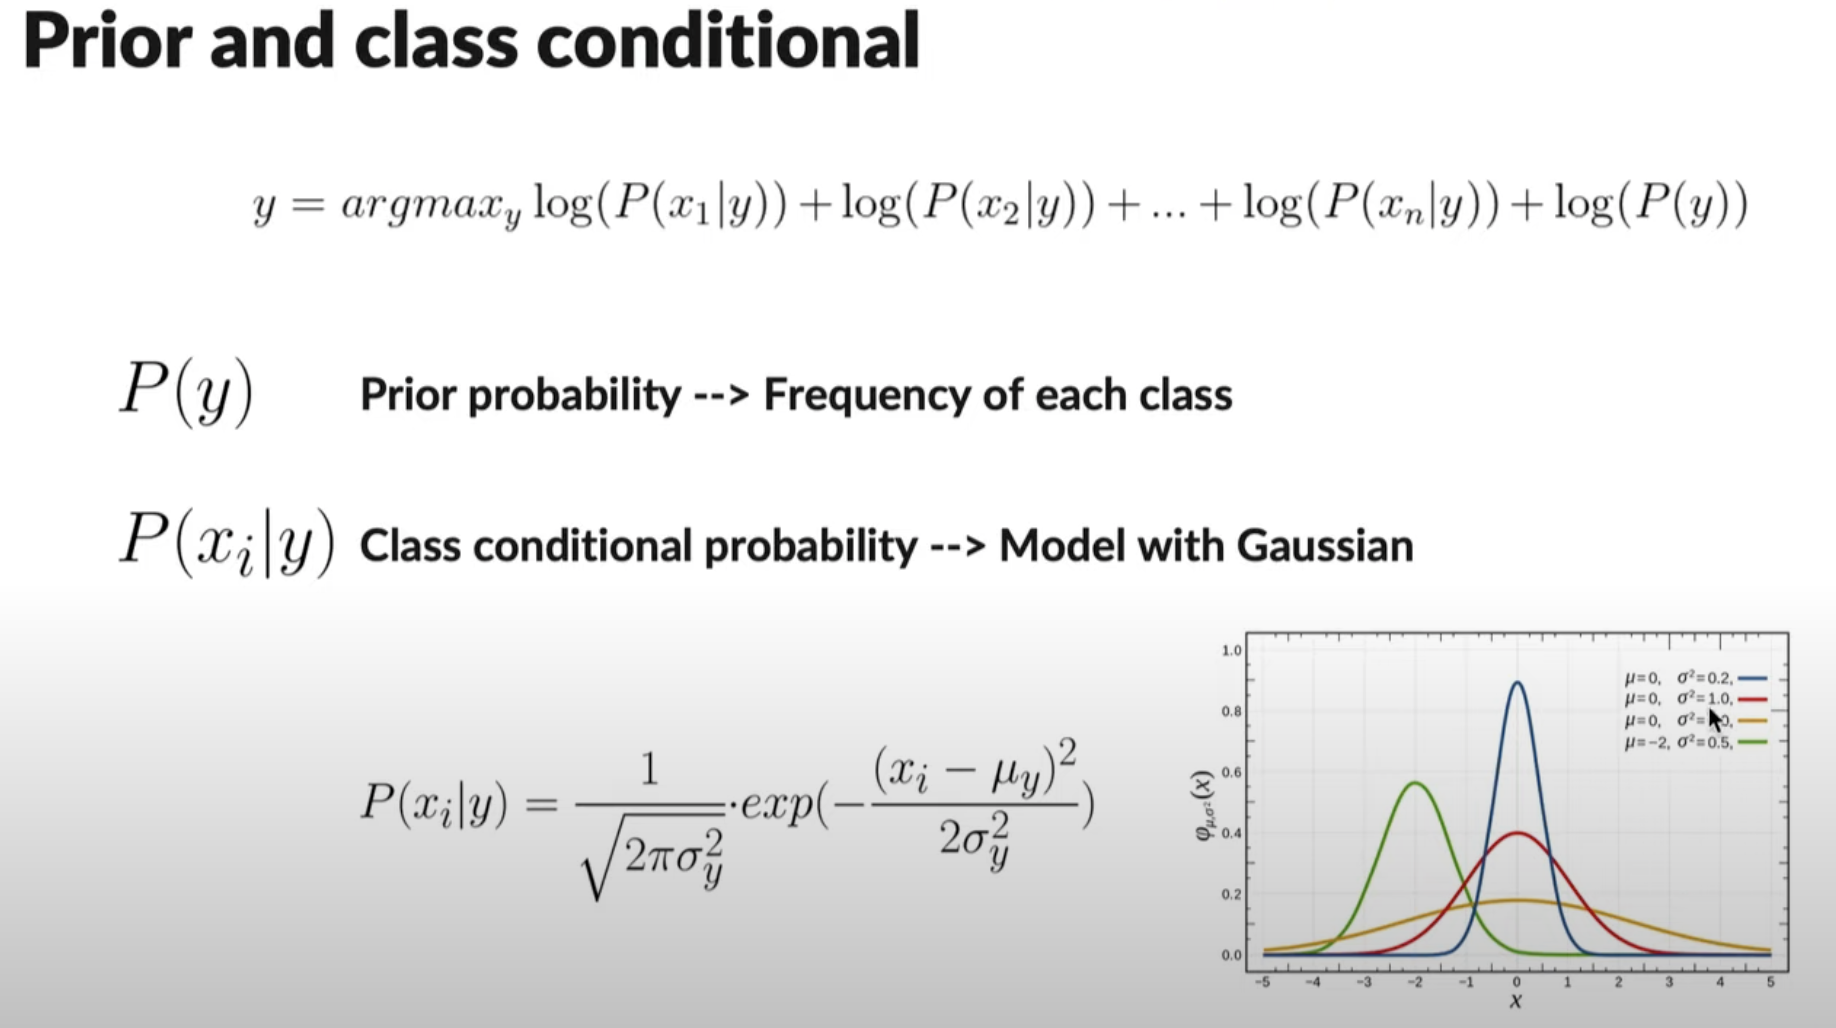

The parameters that are learned in Naive Bayes are the prior probabilities of different classes, as well as the likelihood of different features for each class. In the test phase, these learned parameters are used to estimate the probability of each class for the given sample. In other words, in Naive Bayes, for each sample in the test set, the parameters determined during training are used to estimate the probability of that sample belonging to different classes.

For example, ùëÉ(ùëê|ùë•)‚àùùëÉ(ùëê)ùëÉ(ùë•1|ùëê)ùëÉ(ùë•2|ùëê)...ùëù(ùë•ùëõ|ùëê) where ùëê is a class and ùë• is a test sample. All quantities ùëÉ(ùëê) and ùëÉ(ùë•ùëñ|ùëê) are parameters which are determined during training and are used during testing. 

#### Create a Class for Naive Bayes Classification Model

In [16]:
class NaiveBayes:

    def fit(self, x_train, y_train):                # the first train X & Y parameters
        n_samples, n_features = x_train.shape       # get the shape of x (rows and features)
        self._classes = np.unique(y_train)          # gets unique values in y (number of classes)
        n_classes = len(self._classes)              # number of classes
        
        # calculate mean, variance (sigma^2) and prior for each class
        
        # create a shape for all the new variables. first
        self._mean = np.zeros((n_classes, n_features), dtype = np.float64) # mean for each class (2 X 20)
        self._var = np.zeros((n_classes, n_features), dtype = np.float64)  # variance for each class (2 X 20)
        self._priors = np.zeros(n_classes, dtype = np.float64)             # prior probability for each class (2,)
        
        
        for idx,c in enumerate(self._classes):        # idx is 0,1 and c is 0,1
            x_c = x_train[y_train == c]               # taking all the x's from training data for a specifit class
            
            # calculate mean, variance and prior for a specific class for every features (columns)
            # "axis 0‚Äù goes along rows direction
            
            self._mean[idx,:] = x_c.mean(axis=0)      
            self._var[idx,:] = x_c.var(axis=0)
            self._priors[idx] = x_c.shape[0] / float(n_samples)    #the prior probability of each class is the ratio between number of samples of one class and the total number of samples

    
    # prediction function for the all test dataset
    def predict(self, x_test):
        y_predict = [self._predict(x) for x in x_test] # returns all the predicted values for the test dataset
        return y_predict

    def _predict(self, x):    # predicts the class for one dataset
        posteriors = []       # contanins the posterior values for all classes and will return the max value to determine wjich class the dataset belongs to

        for idx in range(len(self._classes)):    #calculating the posterior value for each class
            prior = np.log(self._priors[idx])    
            class_conditional = np.sum(np.log(self._pdf(idx, x)))
            posterior = prior + class_conditional
            posteriors.append(posterior)
    
        return self._classes[np.argmax(posteriors)]

    def _pdf(self, class_idx, x): # uses gaussian function to calculate the probability density function/conditional probability
        mean = self._mean[class_idx] # calculated previously for each class [it's a vector of mean for all features]
        var = self._var[class_idx]   # calculated previously for each class [it's a vector of variance for all features]
        numerator = np.exp(- (x-mean)**2 / (2 * var)) 
        denominator = np.sqrt(2 * np.pi * var)
        return (numerator/denominator) 


In [17]:
# separating the features and labels from the dataset
X = df_nb.drop(['HeartDisease'],axis=1) 
Y = df_nb['HeartDisease']

# spliting the dataset into training and testing 80%-20%
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2, random_state = 42)

In [18]:
type(X_train)

pandas.core.frame.DataFrame

In [19]:
model = NaiveBayes()       # creating an object for NaiveBayes class
model.fit(X_train,Y_train) # fitting the model

In [20]:
X_test = np.array(X_test)                  # converting testing dataset into numpy array
Y_pred = model.predict(X_test)             # predicting the model
acc = accuracy_score(Y_test, Y_pred)       # getting the accuracy of the model
print('Accuracy Score: ', acc)             # 0.8641304347826086

Accuracy Score:  0.8641304347826086


In [21]:
print(confusion_matrix(Y_test, Y_pred)) # 70 7 18 89
print(f1_score(Y_test, Y_pred))         #0.8768472906403941

[[70  7]
 [18 89]]
0.8768472906403941


In [22]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85        77
           1       0.93      0.83      0.88       107

    accuracy                           0.86       184
   macro avg       0.86      0.87      0.86       184
weighted avg       0.87      0.86      0.86       184



## 2. KNN

K-Nearest Neighbors Classifier first stores the training examples. During prediction, when it encounters a new instance (or test example) to predict, it finds the K number of training instances nearest to this new instance.  Then assigns the most common class among the K-Nearest training instances to this test instance.

1. For implementing any algorithm, we need dataset. So during the first step of KNN, we must load the training as well as test data.

2. Next, we need to choose the value of K i.e. the nearest data points. K can be any integer(mainly odd).

3. Calculate the distance between test data and each row of training data with the help of any of the method namely: Euclidean, Manhattan or Hamming distance. The most commonly used method to calculate distance is Euclidean.

4. Based on the distance value, sort them in ascending order.

5. It will choose the top K rows from the sorted array.

6. It will assign a class to the test point based on most frequent class of these rows.

### Buiding KNN Model

In [23]:
class k_nearest_neighbors:

    # Initialization
    def __init__(self, n_neighbors=5):  # default neighbors to be returned
        self.n_neighbors = n_neighbors

    # Euclidian Distance
    def euclidean_distance(self, a, b):
        eucl_distance = 0.0  # initializing eucl_distance at 0
        for index in range(len(a)):
            eucl_distance += (a[index] - b[index]) ** 2
            euclidian_distance = np.sqrt(eucl_distance)
        return euclidian_distance

    # Fit k Nearest Neighbors
    def fit_knn(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    # Predict X for kNN
    def predict_knn(self, X):
        prediction_knn = []
        for index in range(len(X)):       # Main loop iterating through len(X)
            euclidian_distances = []      # initialize euclidian_distances as empty list
            for row in self.X_train:
                eucl_distance = self.euclidean_distance(row, X[index])    # for every row in X_train, find eucl_distance to X using
                euclidian_distances.append(eucl_distance)                 # euclidean_distance() and append to euclidian_distances list

            neighbors = np.array(euclidian_distances).argsort()[: self.n_neighbors] # sort euclidian_distances in ascending order, and retain only k

            count_neighbors = {}          # initialize dict to count class occurrences in y_train

            for val in neighbors:
                if self.y_train[val] in count_neighbors:
                    count_neighbors[self.y_train[val]] += 1
                else:
                    count_neighbors[self.y_train[val]] = 1

            # max count labels to prediction_knn
            prediction_knn.append(max(count_neighbors, key=count_neighbors.get))

        return prediction_knn

    # Print/display list of nearest_neighbors + corresponding euclidian
    # distance
    def display_knn(self, x):

        # initialize euclidian_distances as empty list
        euclidian_distances = []

        # for every row in X_train, find eucl_distance to x
        # using euclidean_distance() and append to euclidian_distances list
        for row in self.X_train:
            eucl_distance = self.euclidean_distance(row, x)
            euclidian_distances.append(eucl_distance)

        # sort euclidian_distances in ascending order, and retain only k
        # neighbors as specified in n_neighbors (n_neighbors = k)
        neighbors = np.array(euclidian_distances).argsort()[: self.n_neighbors]

        # initiate empty display_knn_values list
        display_knn_values = []

        for index in range(len(neighbors)):
            neighbor_index = neighbors[index]
            e_distances = euclidian_distances[index]
            display_knn_values.append(
                (neighbor_index, e_distances)
            )  # changed to list of tuples
        # print(display_knn_values)
        return display_knn_values

### Data Manipulation

In [24]:
df_knn = final_dataFrame.copy()

In [25]:
df_knn.shape

(918, 21)

In [26]:
Y_ = df_knn.HeartDisease.values # Y is now a numpy array
X_ = df_knn.drop(['HeartDisease'],axis=1)
X_.head()

Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  F  M  N  Y  ASY  \
0   40        140          289          0    172      0.0  0  1  1  0    0   
1   49        160          180          0    156      1.0  1  0  1  0    0   
2   37        130          283          0     98      0.0  0  1  1  0    0   
3   48        138          214          0    108      1.5  1  0  0  1    1   
4   54        150          195          0    122      0.0  0  1  1  0    0   

   ATA  NAP  TA  LVH  Normal  ST  Down  Flat  Up  
0    1    0   0    0       1   0     0     0   1  
1    0    1   0    0       1   0     0     1   0  
2    1    0   0    0       0   1     0     0   1  
3    0    0   0    0       1   0     0     1   0  
4    0    1   0    0       1   0     0     0   1

### Split Data

In [27]:
#now the data is split into 80%-20% where the 20% test data is completely untouched
#the rest 80% data (train-validation) are then divided into 4 folds for cross validation

X_train_val, X_test_2, Y_train_val, Y_test_2 = train_test_split(X_, Y_, train_size = 0.8, random_state = 42)

### Scale Data

In [28]:
# Scaling Training and testing data seperately to avoid leakage

scaler = StandardScaler()
scaler.fit(X_train_val)
scaled_X_train_val = scaler.transform(X_train_val)
scaled_X_test_2 = scaler.transform(X_test_2)

In [29]:
type(scaled_X_train_val)

numpy.ndarray

### Creating KNN Class Instance

In [30]:
classifier = k_nearest_neighbors(n_neighbors=5)

In [31]:
classifier.fit_knn(scaled_X_train_val, Y_train_val)
predict = classifier.predict_knn(scaled_X_test_2)
scores = accuracy_score(Y_test_2, predict)

In [32]:
scores

0.8586956521739131

### K Fold Cross Validation

In [33]:
scaled_X_train_val = pd.DataFrame(scaled_X_train_val, columns = X_.columns)

In [34]:
scaled_X_train_val['HeartDisease'] = Y_train_val.tolist()

In [35]:
scaled_X_train_val

Age  RestingBP  Cholesterol  FastingBS     MaxHR   Oldpeak  \
0   -1.245067  -0.708985     0.372803   1.842609  2.284353 -0.097061   
1   -1.886236  -0.166285     0.086146  -0.542709  1.652241 -0.836286   
2    0.250993   0.919115     0.123134   1.842609 -0.441628  0.087745   
3   -1.779375  -0.166285     0.104640  -0.542709  0.229991 -0.836286   
4   -0.283314  -0.708985    -1.846478   1.842609 -1.271274 -0.836286   
..        ...        ...          ...        ...       ...       ...   
729 -0.603898  -0.708985     0.502261  -0.542709 -1.034232 -0.836286   
730 -0.924483  -0.708985     0.234098  -0.542709  0.150977 -0.836286   
731  0.678439  -0.166285     0.493014  -0.542709  0.309005  0.457358   
732  0.678439   1.027656    -1.846478  -0.542709 -0.718176 -0.836286   
733 -1.458790   0.919115     1.778348  -0.542709 -0.244093  1.011777   

            F         M         N         Y       ASY       ATA       NAP  \
0   -0.540605  0.540605  0.838461 -0.838461 -1.097362 -0.483336  1.879059   
1   -0.540605  0.540605  0.838461 -0.838461 -1.097362 -0.483336  1.879059   
2   -0.540605  0.540605 -1.192662  1.192662  0.911276 -0.483336 -0.532181   
3    1.849780 -1.849780  0.838461 -0.838461 -1.097362 -0.483336  1.879059   
4   -0.540605  0.540605  0.838461 -0.838461  0.911276 -0.483336 -0.532181   
..        ...       ...       ...       ...       ...       ...       ...   
729  1.849780 -1.849780  0.838461 -0.838461  0.911276 -0.483336 -0.532181   
730 -0.540605  0.540605  0.838461 -0.838461  0.911276 -0.483336 -0.532181   
731 -0.540605  0.540605 -1.192662  1.192662  0.911276 -0.483336 -0.532181   
732 -0.540605  0.540605 -1.192662  1.192662  0.911276 -0.483336 -0.532181   
733  1.849780 -1.849780  0.838461 -0.838461  0.911276 -0.483336 -0.532181   

           TA       LVH    Normal        ST      Down     Flat        Up  \
0   -0.213504 -0.504679  0.808179 -0.487621  3.780432 -1.03325 -0.847921   
1   -0.213504 -0.504679  0.808179 -0.487621 -0.264520 -1.03325  1.179356   
2   -0.213504 -0.504679  0.808179 -0.487621 -0.264520  0.96782 -0.847921   
3   -0.213504 -0.504679  0.808179 -0.487621 -0.264520 -1.03325  1.179356   
4   -0.213504 -0.504679  0.808179 -0.487621 -0.264520  0.96782 -0.847921   
..        ...       ...       ...       ...       ...      ...       ...   
729 -0.213504 -0.504679 -1.237350  2.050774 -0.264520 -1.03325  1.179356   
730 -0.213504 -0.504679  0.808179 -0.487621 -0.264520 -1.03325  1.179356   
731 -0.213504 -0.504679  0.808179 -0.487621 -0.264520 -1.03325  1.179356   
732 -0.213504 -0.504679 -1.237350  2.050774 -0.264520 -1.03325  1.179356   
733 -0.213504 -0.504679  0.808179 -0.487621 -0.264520  0.96782 -0.847921   

     HeartDisease  
0               0  
1               0  
2               1  
3               0  
4               1  
..            ...  
729             0  
730             0  
731             1  
732             0  
733             1  

[734 rows x 21 columns]

In [36]:
#four folds - 80% of the original data 

cv_1 = scaled_X_train_val.iloc[0:183]                                            
cv_2 = scaled_X_train_val.iloc[184:367]
cv_3 = scaled_X_train_val.iloc[368:551]
cv_4 = scaled_X_train_val.iloc[552:733]

In [37]:
#creating four different train-test split 

train_model_1 = pd.concat([cv_1, cv_2, cv_3])
test_model_1 = cv_4

train_model_2 = pd.concat([cv_1, cv_2, cv_4])
test_model_2 = cv_3

train_model_3 = pd.concat([cv_1, cv_3, cv_4])
test_model_3 = cv_2

train_model_4 = pd.concat([cv_2, cv_3, cv_4])
test_model_4 = cv_1

In [38]:
# seperating the X and Y in each fold

train_model_1_Y = train_model_1.HeartDisease.values
train_model_1_X = train_model_1.drop(['HeartDisease'],axis=1)
test_model_1_Y = test_model_1.HeartDisease.values
test_model_1_X = test_model_1.drop(['HeartDisease'],axis=1)

train_model_2_Y = train_model_2.HeartDisease.values
train_model_2_X = train_model_2.drop(['HeartDisease'],axis=1)
test_model_2_Y = test_model_2.HeartDisease.values
test_model_2_X = test_model_2.drop(['HeartDisease'],axis=1)

train_model_3_Y = train_model_3.HeartDisease.values
train_model_3_X = train_model_3.drop(['HeartDisease'],axis=1)
test_model_3_Y = test_model_3.HeartDisease.values
test_model_3_X = test_model_3.drop(['HeartDisease'],axis=1)

train_model_4_Y = train_model_4.HeartDisease.values
train_model_4_X = train_model_4.drop(['HeartDisease'],axis=1)
test_model_4_Y = test_model_4.HeartDisease.values
test_model_4_X = test_model_4.drop(['HeartDisease'],axis=1)

### Convert All Folds to Numpy Array

In [39]:
train_model_1_X = train_model_1_X.to_numpy()
train_model_2_X = train_model_2_X.to_numpy()
train_model_3_X = train_model_3_X.to_numpy()
train_model_4_X = train_model_4_X.to_numpy()

test_model_1_X = test_model_1_X.to_numpy()
test_model_2_X = test_model_2_X.to_numpy()
test_model_3_X = test_model_3_X.to_numpy()
test_model_4_X = test_model_4_X.to_numpy()

In [40]:
k_range = range(1, 50)
k_score = []            # accuracy score for all the folds

for k in k_range:
    
    classifier1 = k_nearest_neighbors(n_neighbors=k)
    classifier2 = k_nearest_neighbors(n_neighbors=k)
    classifier3 = k_nearest_neighbors(n_neighbors=k)
    classifier4 = k_nearest_neighbors(n_neighbors=k)
    
    classifier1.fit_knn(train_model_1_X, train_model_1_Y)
    classifier2.fit_knn(train_model_2_X, train_model_2_Y)
    classifier3.fit_knn(train_model_3_X, train_model_3_Y)
    classifier4.fit_knn(train_model_4_X, train_model_4_Y)
    
    predict1 = classifier1.predict_knn(test_model_1_X)
    predict2 = classifier2.predict_knn(test_model_2_X)
    predict3 = classifier3.predict_knn(test_model_3_X)
    predict4 = classifier4.predict_knn(test_model_4_X)
    
    
    acc_scores1 = accuracy_score(test_model_1_Y, predict1)
    acc_scores2 = accuracy_score(test_model_2_Y, predict2)
    acc_scores3 = accuracy_score(test_model_3_Y, predict3)
    acc_scores4 = accuracy_score(test_model_4_Y, predict4)
    
    
    model_1_error = 1 - accuracy_score(test_model_1_Y, predict1)
    model_2_error = 1 - accuracy_score(test_model_2_Y, predict2)
    model_3_error = 1 - accuracy_score(test_model_3_Y, predict3)
    model_4_error = 1 - accuracy_score(test_model_4_Y, predict4)
    
    k_score.append((model_1_error + model_2_error + model_3_error + model_4_error) / 4)

In [41]:
tmp = min(k_score)
index = k_score.index(tmp)

print(index)


41


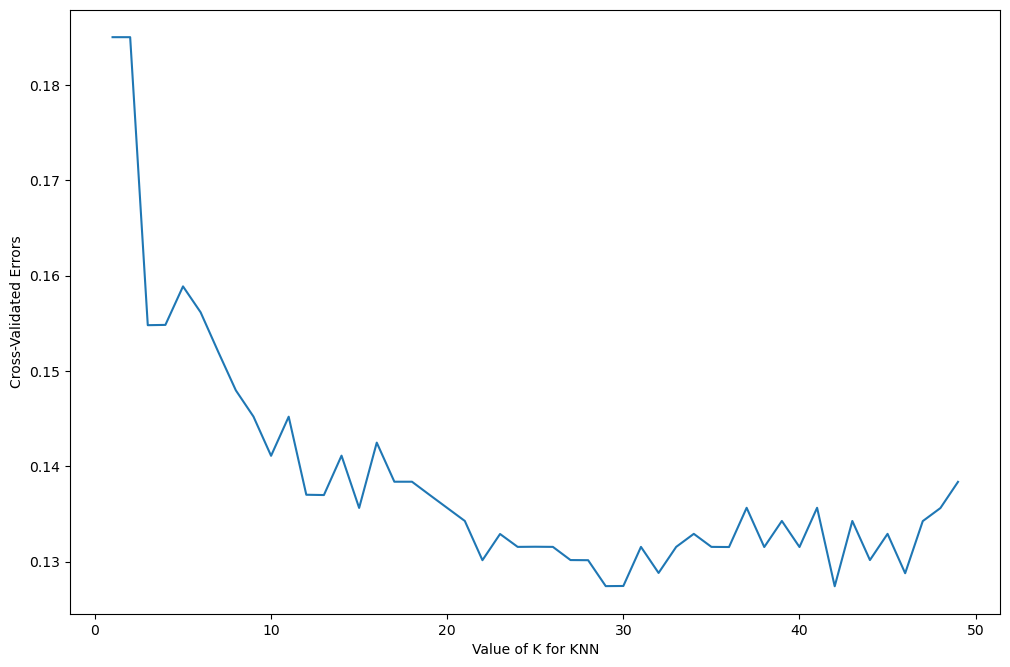

In [42]:
# plot to see clearly
from matplotlib.pyplot import figure

figure(figsize=(12, 8), dpi=100)

plt.plot(k_range, k_score)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Errors')
plt.show()

In [43]:
#scaled_X_train_val

In [44]:
#scaled_X_test_2

In [45]:
scaled_X_train_val_numpy = scaled_X_train_val.to_numpy()

### Testing Dataset

In [46]:
classifier_final = k_nearest_neighbors(n_neighbors=29)

In [47]:
classifier_final.fit_knn(scaled_X_train_val_numpy, Y_train_val)
predict = classifier.predict_knn(scaled_X_test_2)
scores = accuracy_score(Y_test_2, predict)

In [48]:
scores #0.8586956521739131

0.8586956521739131

In [49]:
print(confusion_matrix(Y_test_2, predict)) 
print(classification_report(Y_test_2, predict))  #[[68  9] [17 90]]

[[68  9]
 [17 90]]
              precision    recall  f1-score   support

           0       0.80      0.88      0.84        77
           1       0.91      0.84      0.87       107

    accuracy                           0.86       184
   macro avg       0.85      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184



### Using Scikit Libraries

In [50]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [51]:
knn = KNeighborsClassifier(metric='euclidean')

In [52]:
operations = [('scaler',scaler),('knn',knn)]

In [53]:
pipe = Pipeline(operations)

In [54]:
k_values = list(range(1,50))

In [55]:
param_grid = {'knn__n_neighbors': k_values}

In [56]:
full_cv_classifier = GridSearchCV(pipe,param_grid,cv=5,scoring='accuracy')

In [57]:
df_knn_model = final_dataFrame.copy()
X_knn_model = df_knn_model.drop('HeartDisease',axis=1)
Y_knn_model = df_knn_model['HeartDisease']

In [58]:
X_train_knn_, X_test_knn_, Y_train_knn_, Y_test_knn_ = train_test_split(X_knn_model, Y_knn_model, test_size=0.2, random_state=42)

In [59]:
full_cv_classifier.fit(X_train_knn_,Y_train_knn_)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn',
                                        KNeighborsClassifier(metric='euclidean'))]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29, 30, ...]},
             scoring='accuracy')

In [60]:
full_cv_classifier.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(metric='euclidean', n_neighbors=29))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(metric='euclidean', n_neighbors=29),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'euclidean',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 29,
 'knn__p': 2,
 'knn__weights': 'uniform'}

### Final Model

In [61]:
scaler = StandardScaler()
knn29 = KNeighborsClassifier(n_neighbors=29)
operations = [('scaler',scaler),('knn29',knn29)]

In [62]:
pipe = Pipeline(operations)
pipe.fit(X_train_knn_,Y_train_knn_)
pipe_pred = pipe.predict(X_test_knn_)

In [63]:
print(confusion_matrix(Y_test_knn_,pipe_pred))

[[66 11]
 [16 91]]


In [64]:
print(classification_report(Y_test_knn_,pipe_pred))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83        77
           1       0.89      0.85      0.87       107

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.86      0.85      0.85       184

